In [14]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
#IMPORTING THE DATASET
data = pd.read_csv('eureka_data_final_2019-01-01_2019-03-01.csv', low_memory=False)
data['Label'] = np.where(data['converted_in_7days'] > 0, 1, 0)


In [3]:
columns = ['DemoReqPg_CallClicks_evt_count', 'air_purifier_page_top', 'bounces', 'bounces_hist', 'checkout_page_top',
           'client_id', 'contactus_top', 'converted_in_7days', 'country', 'customer_service_amc_login_top',
           'customer_service_request_login_top', 'date', 'demo_page_top', 'device', 'dsls',
           'fired_DemoReqPg_CallClicks_evt', 'fired_help_me_buy_evt', 'fired_phone_clicks_evt', 'goal4Completions',
           'help_me_buy_evt_count', 'help_me_buy_evt_count_hist', 'newUser', 'offer_page_top', 'pageviews',
           'pageviews_hist', 'paid', 'paid_hist', 'phone_clicks_evt_count', 'phone_clicks_evt_count_hist', 'region',
           'security_solutions_page_top', 'sessionDuration', 'sessionDuration_hist', 'sessions', 'sessions_hist',
           'sourceMedium', 'storelocator_top', 'successbookdemo_top', 'vacuum_cleaner_page_top',
           'visited_air_purifier_page', 'visited_air_purifier_page_hist', 'visited_checkout_page',
           'visited_checkout_page_hist', 'visited_contactus', 'visited_contactus_hist',
           'visited_customer_service_amc_login', 'visited_customer_service_amc_login_hist',
           'visited_customer_service_request_login', 'visited_customer_service_request_login_hist', 'visited_demo_page',
           'visited_demo_page_hist', 'visited_offer_page', 'visited_offer_page_hist', 'visited_security_solutions_page',
           'visited_security_solutions_page_hist', 'visited_storelocator', 'visited_storelocator_hist',
           'visited_successbookdemo', 'visited_vacuum_cleaner_page', 'visited_vacuum_cleaner_page_hist',
           'visited_water_purifier_page', 'visited_water_purifier_page_hist', 'water_purifier_page_top']

results = {}
for column in columns:
    temp_data = data[['Label', column]].replace([np.inf, -np.inf], np.nan)
    temp_data.dropna(inplace=True)

    if temp_data[column].dtype != 'O':
        correlation, _ = pointbiserialr(temp_data['Label'], temp_data[column])
        results[column] = correlation

sorted_results = sorted(results.items(), key=lambda item: abs(item[1]), reverse=True)
results = dict(sorted_results)



/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [6]:
#LOGISTIC REGRESSION

keys = list(results.keys())
keys = keys[1:]


x = data[keys]
y = data['Label']

imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(x)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

#80/20 Rule
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=50)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

TP = conf_matrix[1][1]
FN = conf_matrix[1][0]
TN = conf_matrix[0,0]
FP = conf_matrix[0,1]

#Calculation for True Postitive and True Negative
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print(f'Accuracy: {accuracy * 100: .1f}%')
print(f'True Positive Rate: {TPR * 100: .1f}%')
print(f'True Negative Rate: {TNR * 100: .1f}%')
print()
print("Confusion Matrix:\n", conf_matrix)

Accuracy:  99.4%
True Positive Rate:  0.0%
True Negative Rate:  100.0%

Confusion Matrix:
 [[10006     3]
 [   53     0]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


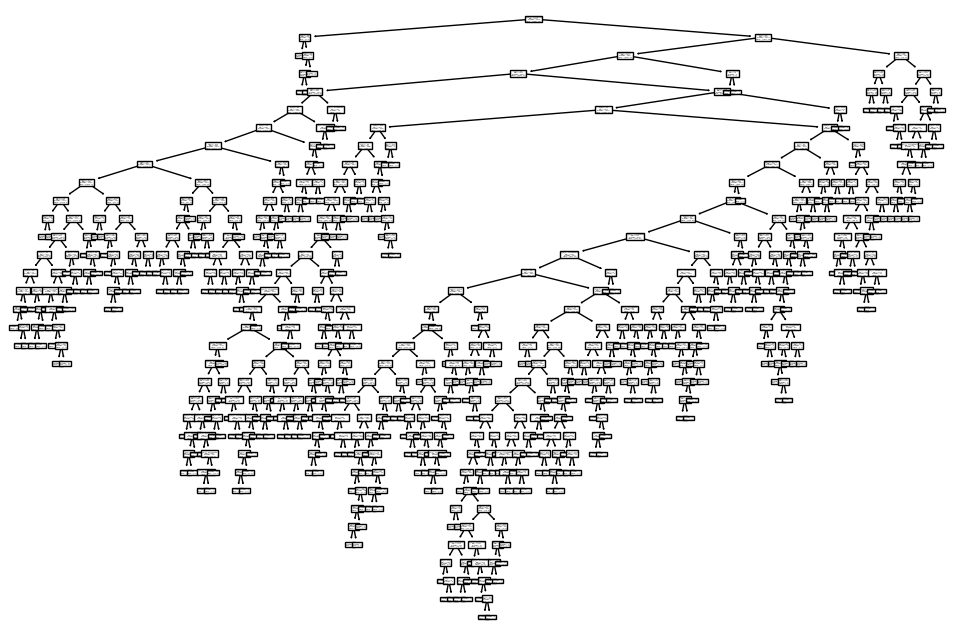

In [8]:
#Decision Tree Model

keys = list(results.keys())
keys = keys[1:]
x = data[keys]
y = data['Label']

x_clean = x.dropna()
y_clean = y[x_clean.index]


clf = DecisionTreeClassifier()
clf.fit(x_clean, y_clean)

fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(clf, ax=ax)
plt.show()

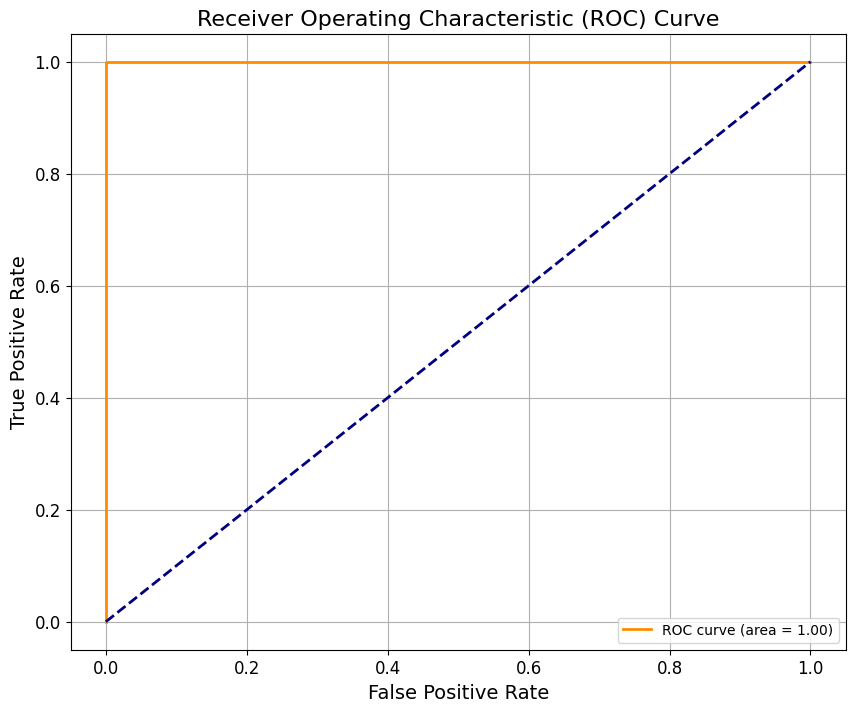

In [15]:

#AUC
# Load data
iris = load_iris()
x, y = iris.data, iris.target

# Convert to binary classification problem
y = (y == 2).astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Calculate predicted probabilities on the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)  # Add grid
plt.xticks(fontsize=12)  # Adjust the xticks font size
plt.yticks(fontsize=12)  # Adjust the yticks font size
plt.show()


In [13]:

# Calculate correlations and filter columns
results = {}
for column in columns:
    temp_data = data[['Label', column]].replace([np.inf, -np.inf], np.nan).dropna()
    if temp_data[column].dtype != 'O':  # Exclude non-numeric columns for correlation
        correlation, _ = pointbiserialr(temp_data['Label'], temp_data[column])
        results[column] = correlation

sorted_results = sorted(results.items(), key=lambda item: abs(item[1]), reverse=True)
results = dict(sorted_results)
keys = list(results.keys())[1:]  # Assuming we exclude the first key for some reason

# Select data for the model
x = data[keys]
y = data['Label']

# Handle NaN values by imputation
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Build and train the Random Forest Model
model = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the Model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=[keys[i] for i in range(len(X_train[0]))],  # Re-assign the correct feature names
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


[[175906      0]
 [   698      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175906
           1       0.00      0.00      0.00       698

    accuracy                           1.00    176604
   macro avg       0.50      0.50      0.50    176604
weighted avg       0.99      1.00      0.99    176604

Accuracy: 0.996047654639759
                                             importance
fired_DemoReqPg_CallClicks_evt                 0.098552
DemoReqPg_CallClicks_evt_count                 0.095211
goal4Completions                               0.088168
visited_demo_page_hist                         0.079123
successbookdemo_top                            0.075695
sessionDuration_hist                           0.050579
demo_page_top                                  0.049271
paid_hist                                      0.047940
pageviews_hist                                 0.033282
sessions_hist                                  0.032856
visited_successbookdemo      

In [12]:
#SMOTE

data = data.dropna(how='any')
x = data[keys]
y = data['Label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Apply SMOTE to augment the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the balance of the augmented data
print("Before SMOTE:", sum(y_train == 0), "minority class and", sum(y_train == 1), "majority class.")
print("After SMOTE:", sum(y_train_smote == 0), "minority class and", sum(y_train_smote == 1), "majority class.")

# Train a Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

Before SMOTE: 439790 minority class and 1717 majority class.
After SMOTE: 439790 minority class and 439790 majority class.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      0.32      0.49    146572
           1       0.01      0.87      0.01       598

    accuracy                           0.32    147170
   macro avg       0.50      0.60      0.25    147170
weighted avg       0.99      0.32      0.49    147170

